# Robust SVM (WORK IN PROGRESS)

Support Vector Machines (SVMs) are a set of supervised learning methods primarily used for classification. A Robust SVM is a variation of the standard SVM designed to handle data that is noisy or contains outliers more effectively. While the standard SVM focuses on finding a hyperplane that best separates classes by maximizing the margin between them, a Robust SVM aims to improve the model’s performance and stability in the presence of noise and outliers.

In this notebook, we will consider example 4.5 introduced in Ali, Kolter, Diamond, and Boyd (2015) [1]. Based on the data given, we can reformulate the optimization problem as:

$$
\begin{aligned}
& \text{minimize} \quad \frac{1}{2} \| w \|^2 + C \cdot \vec{1}^T \vec{\xi} \\
& \text{subject to:} \\
& w^T(x_i + u_x) + b \geq 1 - \xi _i\\
&  w^T (x_i + u_y) + b \geq 1 - \xi_i, \\
& \vec{\xi} \geq \vec{0}

\end{aligned}
$$

In [6]:
import numpy as np
import cvxpy as cp
import lropt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

First, we define our data. We have two datasets, both which are normally distributed but have different mean and variance. $N$ is the number of dimensions in the data.

In [7]:
np.random.seed(1)
N=2
M = 100
C = 0.01 #Regularization Constant
V = 2
RHO = 0.1
P = 2
MU_1 = np.array([0, 0])           # Mean for class 1
SIG_1 = np.array([[1, 0.5],       # Covariance for class 1
                  [0.5, 1]])

MU_2 = np.array([3, 3])           # Mean for class 2
SIG_2 = np.array([[1, -0.7],      # Covariance for class 2
                  [-0.7, 1]])

DATA_1= np.random.multivariate_normal(MU_1, SIG_1, M)
DATA_2= np.random.multivariate_normal(MU_2, SIG_2, M)

Next, we can define a function that solves for the Support Vector Machine. This function checks for an uncertainty set. If it isn't present, the function solves the problem in the deterministic case. We use the ellipsoidal uncertainty set, which can be defined by:

$$ \mathcal{U}_{\text{ellips}} = \{Az+b \ | \ \| z\|_2 \le \rho\} $$

We define an uncertain parameter $\mathbf{v}$ using the Ellipsoidal definition with $\rho=0.1, \mathbf{b}$ as the solution of the determininstic problem.

In [8]:
def solve_svm(uncertainty_set=None):
    w = cp.Variable(N)
    b = cp.Variable()
    xi = cp.Variable(N, nonneg=True)
    objective = cp.Minimize(1/V * cp.norm2(w)**V + C * (cp.sum(xi)))
    
    constraints = []

    if uncertainty_set:
        u = lropt.UncertainParameter(N, uncertainty_set=uncertainty_set)
        for i in range(N):
            constraints.append(w@(DATA_1[i] + u) + b >= 1 - xi[i])
            constraints.append(-(w@(DATA_2[i]+ u) + b) >= 1 - xi[i])
            prob = lropt.RobustProblem(objective, constraints)
    else:
        for i in range(N):
            constraints.append(w@(DATA_1[i]) + b >= 1 - xi[i])
            constraints.append(-(w@(DATA_2[i]) + b) >= 1 - xi[i])
            prob = lropt.RobustProblem(objective, constraints)

    prob.solve()
    
    return w.value, b.value

Finally, we can solve the problem. 

In [9]:
v = solve_svm(lropt.Ellipsoidal(p = P,rho=RHO, b = solve_svm()[0]))
w_opt = v[0]
b_opt = v[1]

This is a visualization of the hyperplane and the uncertainty set.

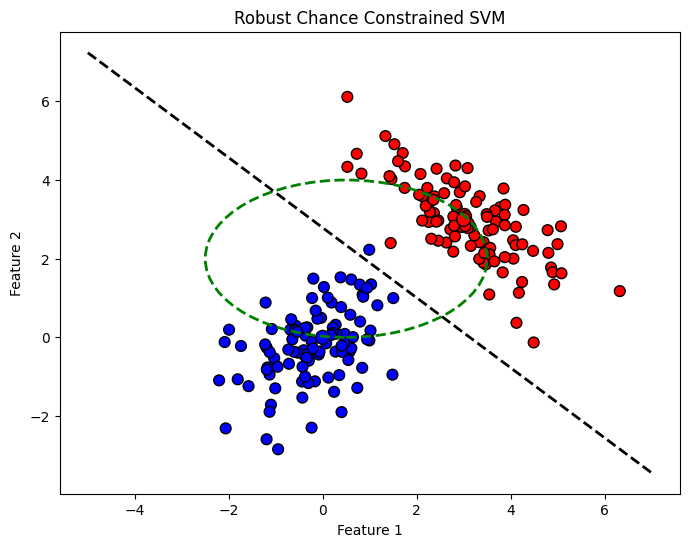

In [10]:
df = pd.DataFrame({
    'Feature 1': np.vstack([DATA_1, DATA_2])[:, 0],
    'Feature 2': np.vstack([DATA_1, DATA_2])[:, 1],
    'Class': ['Class 1'] * M + ['Class 2'] * M
})

colors = {'Class 1': 'blue', 'Class 2': 'red'}
x_range = np.linspace(-5, 7, 100)
y_range = - (w_opt[0] * x_range + b_opt) / w_opt[1]


mean_df = pd.DataFrame({
    'Feature 1': [MU_1[0], MU_2[0]],
    'Feature 2': [MU_1[1], MU_2[1]],
    'Class': ['Class 1', 'Class 2']
})

def plot_ellipsoid(ax, center, covariance, color, label=None):

    vals, vecs = np.linalg.eigh(covariance)
    sort_idx = np.argsort(vals)[::-1]
    vals, vecs = vals[sort_idx], vecs[:, sort_idx]
    

    width, height = 2 * np.sqrt(vals)  
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1])) 
    
    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle,
                      edgecolor=color, facecolor='none', linestyle='--', linewidth=2, label=label)
    ax.add_patch(ellipse)

sigma = np.array([3, 2])
center = np.array([0.5, 2])
covariance = np.diag([sigma_i**2 for sigma_i in sigma])


fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(df['Feature 1'], df['Feature 2'], c=df['Class'].map(colors), label=df['Class'].unique(), s=60, edgecolor='k')
ax.plot(x_range, y_range, color='black', linestyle='--', linewidth=2, label='Decision Boundary')

ax.scatter(mean_df['Feature 1'], mean_df['Feature 2'], c=mean_df['Class'].map(colors), s=100, edgecolor='k', label='Means')
plot_ellipsoid(ax, center, covariance, color='green', label='Uncertainty Set')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('Robust Chance Constrained SVM')
plt.grid(False)
plt.show()

## References

1. Ali, A., Kolter, J. Z., Diamond, S., & Boyd, S. (2015). Disciplined convex stochastic programming: A new framework for stochastic optimization. https://web.stanford.edu/~boyd/papers/dcsp.html Proceedings of the 31st Conference on Uncertainty in Artificial Intelligence.
